
This colab provides a walk-through examples for calculating fractal parameters, as described in the following paper:

```
Alabdulmohsin, Ibrahim, Vinh Q. Tran, and Mostafa Dehghani.
"Fractal Patterns May Unravel the Intelligence in Next-Token Prediction."
arXiv preprint arXiv:2402.01825 (2024).
```


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/fractals_language/fractal_patterns_in_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!nvidia-smi -L  # code was tested with T4
!free -g

GPU 0: Tesla T4 (UUID: GPU-10bb6167-0f81-0360-ed99-971ea5fe3cdd)
               total        used        free      shared  buff/cache   available
Mem:              12           0           7           0           4          11
Swap:              0           0           0


In [ ]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
import datasets
import torch
import tqdm.notebook
import transformers

import numpy as np
import sklearn.linear_model
import jax, jax.numpy as jnp

import matplotlib
import matplotlib.pyplot as plt

np.random.seed(2024)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Utils

In [ ]:
# These default values are different in the paper. For illustration purposes
# here, we use only 100 documents. In the paper, we use 1K documents per domain.
# See the docstrings for how to select arguments carefully.

DEFAULT_SCALES = [25, 50, 75, 100, 200, 300]
DEFAULT_SAMPLES_PER_DOC = 100
DEFAULT_EPS = 5e-2


latex_context = {
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'font.family': 'sans-serif',
    'font.size': 20.0,
    'legend.fontsize': 20.0,
    'axes.labelsize': 20.0,
    'axes.titlesize': 20.0,
    'xtick.labelsize': 20.0,
    'ytick.labelsize': 20.0,
    'axes.axisbelow': True,
}


def power_law_fit(x, y):
  """Fit a power law to the data (x, y)."""
  ones_logx = np.stack([np.ones_like(x), np.log(x)], axis=1)
  logy = np.log(y)
  clf = sklearn.linear_model.LinearRegression(
      fit_intercept=False).fit(ones_logx, logy)
  return clf.coef_[0], clf.coef_[1]  # coeff, exponent


def plot_power_law(x, y,
                   xlabel, ylabel, title='', yscale='',
                   ylim=None, xlim=None, xticks=None, yticks=None):
  """Plot a power law fit to the data (x, y)."""
  if xlim is None:
    minx, maxx = min(x), max(x)
  else:
    minx, maxx = tuple(xlim)

  log_beta, c = power_law_fit(x, y)
  xp = np.linspace(minx, maxx, 100)
  yp = np.exp(log_beta) * np.power(xp, c)

  with matplotlib.rc_context({**latex_context}):
    fig, axes = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

    axes.scatter(x, y, s=200, marker="o")
    axes.plot(xp, yp, 'red')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale('log')
    axes.grid(axis='y')
    axes.set_ylim(ylim)
    axes.set_xlim(xlim)
    if yscale == 'log': axes.set_yscale('log')
    if title: axes.set_title(title)
    if xticks: axes.set_xticks(xticks)
    if yticks: axes.set_yticks(yticks)
  return fig

# Language model
We use GPT2 as an example in this colab demo.

In [ ]:
model_name = 'gpt2'
model = transformers.GPT2LMHeadModel.from_pretrained(model_name).to(device)
tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
MAX_LENGTH = 1024  # gpt2 max supported sequence length

# Dataset

In [ ]:
ds = datasets.load_dataset('scientific_papers', 'arxiv', split='validation')
ds.info

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

DatasetInfo(description='\nScientific papers datasets contains two sets of long and structured documents.\nThe datasets are obtained from ArXiv and PubMed OpenAccess repositories.\n\nBoth "arxiv" and "pubmed" have two features:\n  - article: the body of the document, pagragraphs seperated by "/n".\n  - abstract: the abstract of the document, pagragraphs seperated by "/n".\n  - section_names: titles of sections, seperated by "/n".\n\n', citation='\n@article{Cohan_2018,\n   title={A Discourse-Aware Attention Model for Abstractive Summarization of\n            Long Documents},\n   url={http://dx.doi.org/10.18653/v1/n18-2097},\n   DOI={10.18653/v1/n18-2097},\n   journal={Proceedings of the 2018 Conference of the North American Chapter of\n          the Association for Computational Linguistics: Human Language\n          Technologies, Volume 2 (Short Papers)},\n   publisher={Association for Computational Linguistics},\n   author={Cohan, Arman and Dernoncourt, Franck and Kim, Doo Soon and Bu

When calculating fractal parameters, we calculate them over a collection of documents, to ensure we have enough independent samples when estimating, for example, autocorrelations. In the paper, we used 1K documents per domain. For illustration purposes here, we only use 100.

In [ ]:
num_documents = 100  #@param = 'int'
it = iter(ds)

texts = []
for _ in tqdm.notebook.tqdm(range(num_documents)):
  b = next(it)
  texts.append(b['article'])  # + '\n'
len(texts)

  0%|          | 0/100 [00:00<?, ?it/s]

100

In [ ]:
texts[0]  # example

"the interest in anchoring phenomena and phenomena in confined nematic liquid crystals has largely been driven by their potential use in liquid crystal display devices .\nthe twisted nematic liquid crystal cell serves as an example .\nit consists of a nematic liquid crystal confined between two parallel walls , both providing homogeneous planar anchoring but with mutually perpendicular easy directions . in this case\nthe orientation of the nematic director is tuned by the application of an external electric or magnetic field .\na precise control of the surface alignment extending over large areas is decisive for the functioning of such devices .\nmost studies have focused on nematic liquid crystals in contact with laterally uniform substrates . on the other hand substrate inhomogeneities\narise rather naturally as a result of surface treatments such as rubbing .\nthus the nematic texture near the surface is in fact non - uniform .\nthis non - uniformity , however , is smeared out beyon

In [ ]:
text = texts[0]
tokens = tokenizer.encode(text, return_tensors='pt')

tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (9758 > 1024). Running this sequence through the model will result in indexing errors


tensor([[1169, 1393,  287,  ..., 1267, 1267,  764]])

# Tokenize

In [ ]:
tokens = [tokenizer.encode(texts[i], return_tensors='pt') for i in tqdm.notebook.tqdm(range(len(texts)))]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
tokens[0]

tensor([[1169, 1393,  287,  ..., 1267, 1267,  764]])

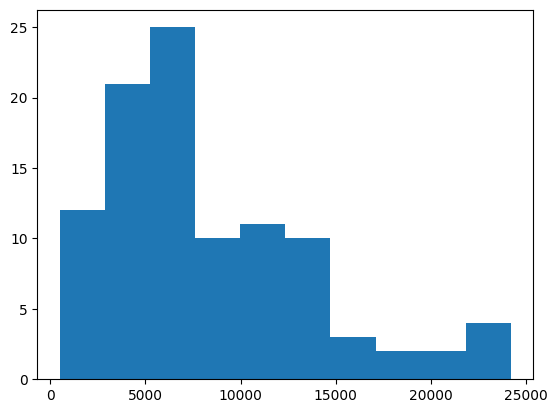

In [ ]:
# distribution of document lengths
_ = plt.hist([tokens[i].shape[1] for i in range(len(tokens))], 10)

We only use sufficiently long documents (e.g. > 2K tokens). Later, we drop the leading 128 tokens (warmup) and use only the first 1K tokens (because the second half can contain links, references, etc, not related to the article itself).

In [ ]:
filtered_tokens = [tokens[i][0, 0: MAX_LENGTH] \
                   for i in range(len(tokens)) \
                   if tokens[i].shape[1] > 2048]

print(len(filtered_tokens), filtered_tokens[0].shape)

torch.Size([1024])


In [ ]:
tokenizer.decode(filtered_tokens[0])  # to recover the original text

'the interest in anchoring phenomena and phenomena in confined nematic liquid crystals has largely been driven by their potential use in liquid crystal display devices.\nthe twisted nematic liquid crystal cell serves as an example.\nit consists of a nematic liquid crystal confined between two parallel walls, both providing homogeneous planar anchoring but with mutually perpendicular easy directions. in this case\nthe orientation of the nematic director is tuned by the application of an external electric or magnetic field.\na precise control of the surface alignment extending over large areas is decisive for the functioning of such devices.\nmost studies have focused on nematic liquid crystals in contact with laterally uniform substrates. on the other hand substrate inhomogeneities\narise rather naturally as a result of surface treatments such as rubbing.\nthus the nematic texture near the surface is in fact non - uniform.\nthis non - uniformity, however, is smeared out beyond a decay l

# Score
Next, we score all the tokens and convert scores to bits, i.e. we calculate: $-\log p(tokens[i]\;|\; tokens[0:i])$.

In [ ]:
all_bits = []
for i in tqdm.notebook.tqdm(range(len(filtered_tokens))):
  ts = filtered_tokens[i].numpy()
  with torch.no_grad():
    logits = model(torch.tensor(ts)[None].to(device)).logits[0].cpu().numpy()
    # convert logits to probability scores over the vocabulary
    p = jax.nn.log_softmax(logits)
    # convert to bits per token
    indices = jnp.array(list(zip(range(len(ts)), ts))).T
    bits = -p[tuple(indices)]

    all_bits.append(bits.tolist()[128:]) # we drop the first 128 tokens (warmpu)

  0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
all_bits = np.array(all_bits)
all_bits.shape

(92, 896)

# Fractal Analysis

## Increment/integral processes

First, let's see how well the model performs. The mean number of bits is the average log-loss.

In [ ]:
bits_mean = np.mean(all_bits)
bits_std = np.std(all_bits)
bits_mean, bits_std

(9.206183209857768, 3.177083467097998)

Now, form the increment $x$ and integral $X$ processes. $x$ is basically the sequence of bits after normalization, while $X$ is the integral of $x$.

In [ ]:
x = []
X = []

for k in tqdm.notebook.tqdm(range(len(all_bits))):
  mu = np.mean(all_bits[k])
  sigma = np.std(all_bits[k])
  x.append((all_bits[k] - mu) / sigma)
  X.append(np.cumsum(x[-1]))

x = np.array(x)
X = np.array(X)
x.shape, X.shape

  0%|          | 0/92 [00:00<?, ?it/s]

((92, 896), (92, 896))

Plot the integral process to see how self-similar it is.

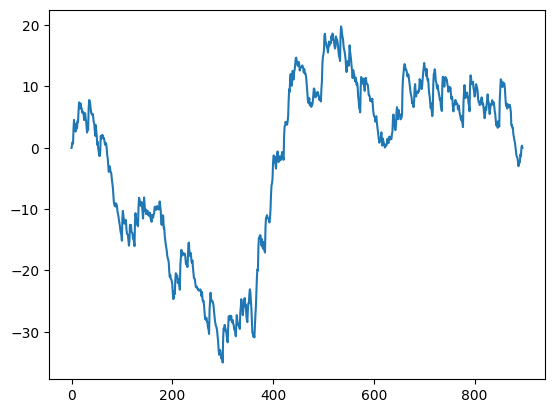

In [ ]:
plt.plot(X[0])

## Self-similarity exponent
Note below that we have a large variance in estimating the self-similarity exponent. This is because: (1) we only use 100 documents (we used 1K in the paper) and (2) the scale level goes up to 300 only (in the paper we used >500). So, if you see a large variance, consider increasing the number of documents and increasing the granularity levels.

In [ ]:
def get_self_sim_exponent(X,
                          scales=DEFAULT_SCALES,
                          samples_per_doc=DEFAULT_SAMPLES_PER_DOC,
                          eps=DEFAULT_EPS):
  """Calculate the self-similarity exponent.

  Args:
    X: integral process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.
    eps: used for calculating peak probability scores. Choose this carefully.
      If eps is too small, probability estimates will be unreliable.
      If eps is too large, it doesn't reflect peak probabiliy at the origin.

  Returns:
    S: self-similarity exponent.
    p0: peak probability estimates.
  """
  if X.ndim == 1:
    X = X.reshape((1, -1))
  elif X.ndim > 2:
    raise ValueError('X.ndim must be 1 or 2.')

  p0 = []
  for n in scales:
    all = []
    for i in (range(len(X))):
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(X[i]) - n)
        all.append(X[i][offset + n] - X[i][offset])
    all = np.array(all)
    p0.append(np.mean(np.abs(all) < eps))

  # estimate Holder exponent
  return -power_law_fit(scales, p0)[1], p0

In [ ]:
# use bootstrapping to estimate uncertainty
np.random.seed(2024)
self_sim_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x)), len(x))  # with replacement
  self_sim_exponent.append(get_self_sim_exponent(X[articles])[0])

print(np.mean(self_sim_exponent), np.std(self_sim_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

0.5761004041394083 0.15908063049317464


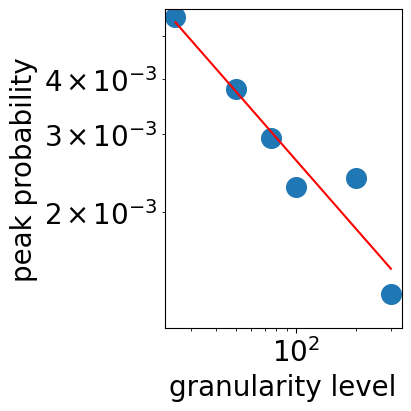

In [ ]:
# see the quality of fit
_, y = get_self_sim_exponent(X)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='granularity level',
                     ylabel='peak probability', )

## Hurst exponent

In [ ]:
def get_hurst_exponent(x,
                       scales=DEFAULT_SCALES,
                       samples_per_doc=DEFAULT_SAMPLES_PER_DOC):
  """Calculate the Hurst exponent.

  Args:
    x: increment process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.

  Returns:
    H: Hurst exponent.
    sr: rescaled range estimates.
  """
  if x.ndim == 1:
    x = x.reshape((1, -1))
  elif x.ndim > 2:
    raise ValueError('x.ndim must be 1 or 2.')

  # calculate the rescaled range
  sr = []
  for n in scales:
    som = 0
    count = 0
    for i in range(len(x)):  # to get a reliable etimate, many documents are needed
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(x[i]) - n)
        y = x[i, offset: n + offset]
        y = y - np.mean(y)
        Y = np.cumsum(y)
        R = max(Y) - min(Y)
        S = np.std(y)
        som += R / S
        count += 1
    sr.append(som / count)

  # estimate Hurst exponent
  return power_law_fit(scales, sr)[1], sr

In [ ]:
hurst_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x)), len(x))  # with replacement
  hurst_exponent.append(get_hurst_exponent(x[articles])[0])

print(np.mean(hurst_exponent), np.std(hurst_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

0.6075745642675432 0.006985823794845016


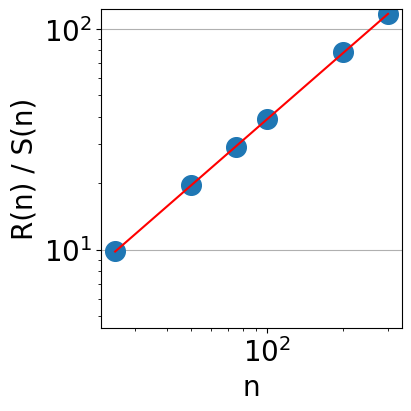

In [ ]:
# see the quality of fit
_, y = get_hurst_exponent(X)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='n',
                     ylabel='R(n) / S(n)')

## Joseph exponent

In [ ]:
def get_joseph_exponent(x,
                        scales=DEFAULT_SCALES,
                        samples_per_doc=DEFAULT_SAMPLES_PER_DOC):
  """Calculate the Joseph exponent.

  Args:
    x: increment process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.

  Returns:
    J: Joseph exponent.
    sigmas: standard deviations estimate.
  """
  if x.ndim == 1:
    x = x.reshape((1, -1))
  elif x.ndim > 2:
    raise ValueError('x.ndim must be 1 or 2.')

  sigmas = []
  v = []
  for n in scales:
    for i in range(len(x)):
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(x[i]) - n)
        v.extend([X[i][offset + n] - X[i][offset]])
    sigmas.append(np.std(v))

  # estimate Joseph exponent
  return power_law_fit(scales, sigmas)[1], sigmas

In [ ]:
joseph_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x)), len(x))  # with replacement
  joseph_exponent.append(get_joseph_exponent(x)[0])

print(np.mean(joseph_exponent), np.std(joseph_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

0.35772080370919374 0.002647717654797778


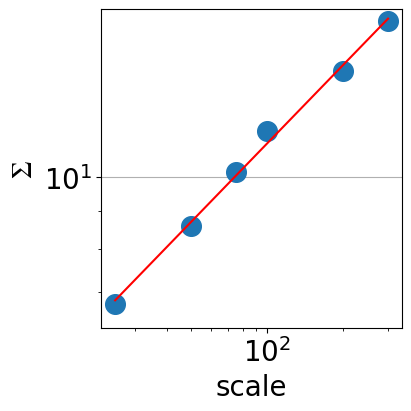

In [ ]:
# see the quality of fit
_, y = get_joseph_exponent(X)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='scale',
                     ylabel='$\Sigma$')